In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

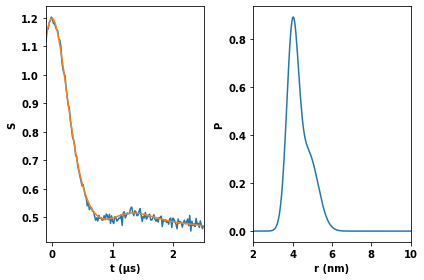

In [2]:
testdata, testpars = dive.generateMultiGauss(nr = 200, nt = 150, seed = 129, r_edges = [2, 10], k = 0.1)

t = testdata['t']
Vexp = testdata['V']
Ptruth = testdata['P']
r = testdata['r']
Vm = testdata['V0']

Vscale = 1.2
Vexp = Vscale*Vexp
Vm = Vscale*Vm

sigma_model = testpars['sigma']


fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, Vexp)
line1 = ax[0].plot(t, Vm)
line2 = ax[1].plot(r, Ptruth)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Initialize parameters and matrices

In [3]:
K0 = dl.dipolarkernel(t,r,integralop=False)   # kernel matrix
K0tK0 = np.matmul(np.transpose(K0),K0)

L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)

a0 = 0.01
b0 = 1e-6

### Setup model

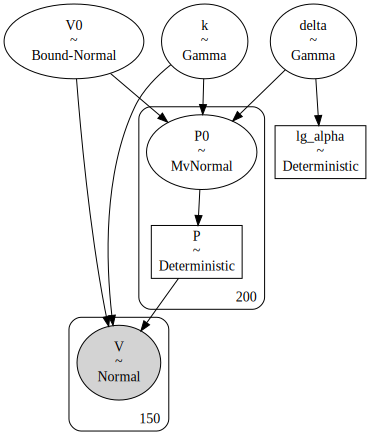

In [4]:
dr = r[1]-r[0]

with pm.Model() as model:

    # Noise
    sigma = sigma_model
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    delta = pm.Gamma('delta', alpha=a0, beta=b0)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Time Domain
    # lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    lamb = 0.5
    # V0 = 1.1
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    # k = 0
    B = dl.bg_exp(t,k)         # background decay

    # Calculate matrices and operators
    Kintra = (1-lamb)+lamb*K0
    Bm = T.transpose(T.tile(B,(len(r),1)))
    K = V0*Kintra*Bm*dr

    KtK = T.dot(T.transpose(K),K)

    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu = testdata['P'], chol = C_L, shape = len(r))    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    Vmodel = pm.math.dot(K,P)

    # Likelihood
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

### Run sampler

In [9]:
with model:
    step_P0 = dive.SampleFullP(P0, delta, sigma, k, lamb, V0, LtL, t, Vexp, r, K0)
    trace = pm.sample(step = step_P0, chains=2, cores=4, draws=4000, tune=2000, return_inferencedata=False, progressbar = False)

KeyboardInterrupt: 

### Analysis

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.112,0.004,0.105,0.119,0.000,0.000,780.0,1384.0,1.0
V₀,1.201,0.003,1.196,1.206,0.000,0.000,1799.0,2946.0,1.0
δ,48882.010,11308.352,28407.912,70703.067,352.136,249.068,976.0,1529.0,1.0
lg(α),0.339,0.051,0.244,0.435,0.002,0.001,976.0,1529.0,1.0


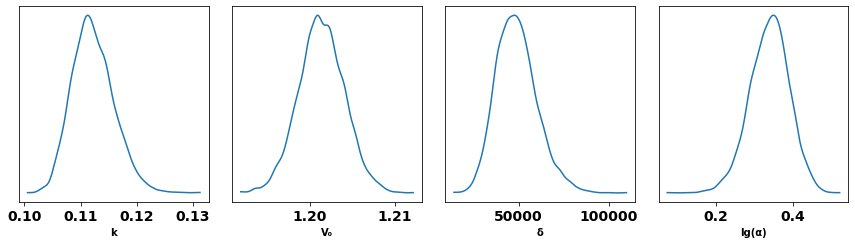

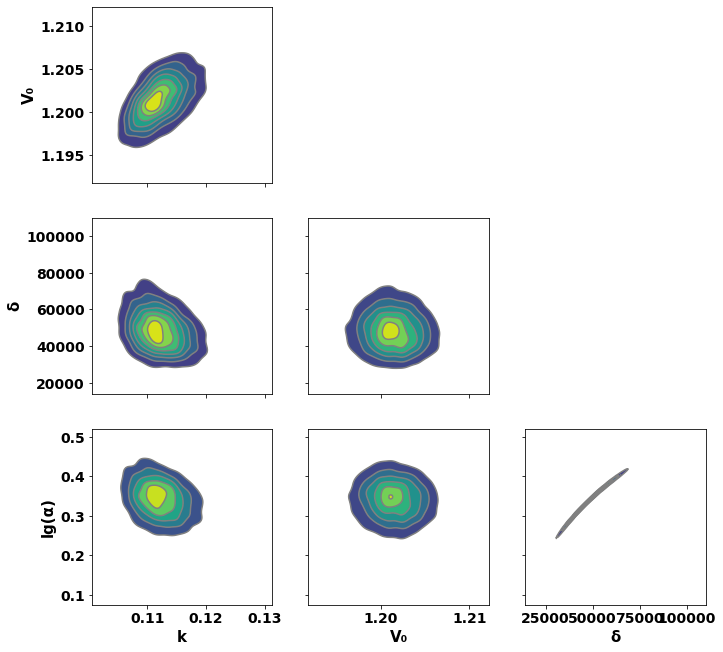

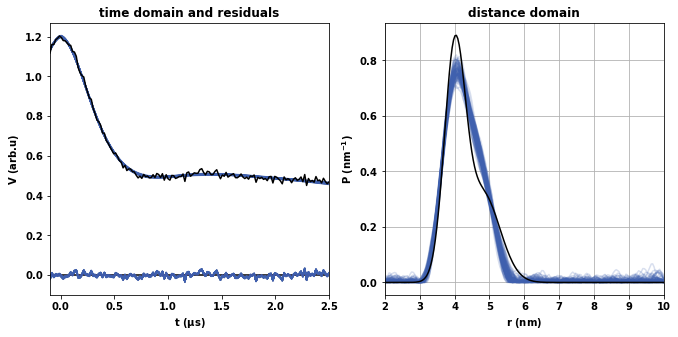

In [10]:
dive.summary(trace, model, Vexp, t, r, Pref = testdata['P'])   